# Predictive Modelling: SVM

# Imports

In [25]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

#
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position
from src.visualization.visualize import plot_confusion_matrix



import time

# scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# For BayesianHyperparameter Optimization
from src.models.hyperparameter_optimization import search_space, BayesianSearch

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Load environment variables
load_dotenv(find_dotenv())

True

## Downloading data

## Defining functions

In [ ]:
MSFT, GPS

In [20]:
def run_combinations(
        symbol,
        forecast_horizon,
        input_window_size,
        X_train,
        X_test,
        y_train,
        y_test,
        prices,
        model,
        hyper_optimize=False,
        n_eval=10,
        silent = False,
    
    ):
    start = time.time()
    cnt = 1
    df_score = pd.DataFrame(index=forecast_horizon, columns=input_window_size, dtype=float)
    df_score.rename_axis('Forecast horizon (days)').rename_axis('Input window (days)', axis=1)
    df_returns = df_score.copy()
    total = len(forecast_horizon)*len(input_window_size)
    # Loop over forecast horizons
    for i, fh in enumerate(forecast_horizon):
        # Loop over input / lookback windows
        for j, iw in enumerate(input_window_size):
            try:
                params = {}
                if hyper_optimize:
                    _, _, params = BayesianSearch(
                        search_space(model),
                        model,
                        X_train[symbol][[f'{x}_{iw}' for x in ti_list]], 
                        y_train[symbol][f'signal_{fh}'], 
                        X_test[symbol][[f'{x}_{iw}' for x in ti_list]],
                        y_test[symbol][f'signal_{fh}'],
                        num_eval=n_eval,
                        silent=True,
                    )
                clf = model(**params)
                clf.fit(X_train[symbol][[f'{x}_{iw}' for x in ti_list]], y_train[symbol][f'signal_{fh}'])
                y_pred = clf.predict(X_test[symbol][[f'{x}_{iw}' for x in ti_list]])
                # Calculate accuracy score ()
                a_score = accuracy_score(y_test[symbol][f'signal_{fh}'], y_pred)
                # Calculate returns generated by stratedy
                returns = calc_returns(y_pred, prices[symbol])
                cum_returns = returns['Cum_Returns_Strat'][-1]
                df_score.iloc[i, j] = a_score
                df_returns.iloc[i, j] = cum_returns
                if silent == False:
                    clear_output(wait=True)
                    display(f'Leg [{cnt} / {total}]; Test Score {a_score}; Test Returns {cum_returns}')
                cnt += 1
            except (KeyboardInterrupt, SystemExit):
                raise
    print(f'Elapsed time {round(time.time()-start, 0)}s.')
    return df_score, df_returns

In [21]:
def avg_model2(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=None,
    silent = False
):
    results_dict, returns_dict = {}, {}
    cnt = 1
    start = time.time()
    for symb in symbol_list:
        results, returns = run_combinations(
            symb,                             
            forecast_horizon,                                 
            input_window_size,                                  
            X_train,    
            X_test,    
            y_train,    
            y_test,    
            prices_test,   
            model=xgb_optm,
            silent=True
        )
        results_dict[symb] = results
        returns_dict[symb] = returns
        
        if silent == False:
            clear_output(wait=True)
            display(f'Leg [{cnt}/{len(symbol_list)}]; Elapsed Time {round(time.time()-start , 0)}s')
        cnt += 1
    avg_results = pd.DataFrame(
        np.array([results_dict[x].values for x in results_dict.keys()]).mean(axis=0),
        columns=results.columns, index=results.index).style.background_gradient(cmap='BuGn')
    return avg_results, results_dict, returns_dict

In [22]:
def avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model,
    silent = False
):
    results_dict, returns_dict = {}, {}
    cnt = 1
    start = time.time()
    for symb in symbol_list:
        results, returns = run_combinations(
            symb,                             
            forecast_horizon,                                 
            input_window_size,                                  
            X_train,    
            X_test,    
            y_train,    
            y_test,    
            prices_test,   
            model=model,
            silent=True
        )
        results_dict[symb] = results
        returns_dict[symb] = returns
        avg_results = pd.DataFrame(
            np.array([results_dict[x].values for x in results_dict.keys()]).mean(axis=0),
            columns=results.columns, index=results.index).style.background_gradient(cmap='BuGn')
        
        if silent == False:
            clear_output(wait=True)
            display(f'Leg [{cnt}/{len(symbol_list)}]; Elapsed Time {round(time.time()-start , 0)}s\n', avg_results)
        cnt += 1

    return avg_results, results_dict, returns_dict

In [23]:
def calc_returns(signals, prices):
    returns = prices[['Close']].pct_change()
    returns['Signal_Strat'] = calc_open_position(signals)
    returns['Cum_Returns_Strat'] = (returns['Signal_Strat'] * returns['Close']).cumsum()
    returns['Cum_Returns_BH'] = returns['Close'].cumsum()
    return returns

## Loading the data

In [5]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')

fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
# Load dataset from HDF storage
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    #print(storage.info())
    
# Create copies of the pristine data
X = df_moments.copy()
y = y_3c.copy()
y2 = y_2c.copy()
prices = djia.copy()

In [6]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']
symbol_list = df_moments.columns.get_level_values(0).unique()

## Imputing missing values

In [7]:
X.shape

(1954, 4800)

In [8]:
check_for_missing_vals(X)

No missing values found in dataframe


Prices values

In [9]:
prices.shape

(1954, 250)

In [10]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [11]:
y_3c.shape

(1954, 450)

In [12]:
check_for_missing_vals(y_3c)

No missing values found in dataframe


In [13]:
y2.shape

(1954, 450)

In [14]:
check_for_missing_vals(y2)

No missing values found in dataframe


No missing values, and sizes of ```y.shape[0]``` and```X.shape[0]``` match.

# Scaling the features

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [22]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [23]:
scaled = scale.fit_transform(X)

In [24]:
scaled.shape

(1954, 4800)

In [25]:
X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
#X_scaled = X

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Train-Test Split

In [15]:
# Use 70/30 train/test splits
test_p = .3

In [ ]:
# Scaled, three-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [16]:
# Unscaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [ ]:
# Scaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [ ]:
#test_size = test_p
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

# Model

In [17]:
symbol = 'T'
n = 15

## Single lookback/lookahead combination

In [ ]:
svc = SVC(kernel='rbf')
#result_matrix = svc.fit('AAPL', forecast_horizon, input_window_size, X_train, X_test, y_train, y_test, svc)

svc.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

In [ ]:
y_pred_svc = svc.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print(classification_report(y_test[symbol][f'signal_{n}'], y_pred_svc))
print(confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_svc))
#plot_feature_importances(svc.coef_,
#                         X_scaled[symbol][[f'{x}_{n}' for x in ti_list]].columns, 
#                         model='SVC1', top_count=100)

## All combinations

'Leg [72 / 72]; Test Score 0.6047700170357752; Test Returns 0.12480497360229492'

Elapsed time 2119.0s.


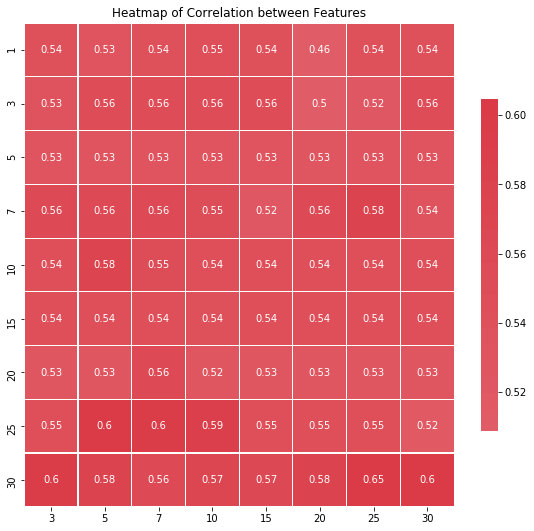

In [24]:
svm2 = SVC
score_svm, returns_svm = run_combinations(
    symbol=symbol,
    forecast_horizon=forecast_horizon,
    input_window_size=input_window_size,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    prices=prices_test,
    model=svm2,
    hyper_optimize=True,
    n_eval=5,
)

plot_corr_matrix(score_svm, mask_upper=False, show_annot=True, figsize=(8, 8))

## Averaging across all 50 randomly selected stocks

In [172]:
avg, _, _ = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    svm2,
    silent = False
)

'Leg [50/50]; Elapsed Time 337.0s\n'

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535


## Hyperparamter Optimization: GridSearch

In [132]:
tscv = TimeSeriesSplit(n_splits=5)

In [128]:
symbol = 'T'
n=30
btscv = BlockingTimeSeriesSplit(n_splits=5)


In [ ]:
start = time.time()

# kernel = 'rbf', 'linear, 'poly'
# gamma only for non-linear kernels (poly, rbf)
# C penalty for error term
# degrees = [0, 1, 2, 3, 4, 5, 6] only for kernel = poly
gammas = [10, 1, 0.1, 0.01, 0.001, 1E-4, 1E-5, 1E-6]
cs = [1, 10, 100, 1000, 1E4, 1E5, 1E6]
param_search = [
    {'kernel': ['rbf'], 'gamma': gammas, 'C': cs},
    #{'kernel': ['poly'], 'gamma': gammas, 'C': cs, 'degree' : [0, 1, 2, 3, 4, 5, 6]},
    #{'kernel': ['linear'], 'C': cs}
]

svm_gs = SVC()
gsearch_svc = GridSearchCV(
    estimator=svm_gs,                   
    cv=tscv,      
    param_grid=param_search,                      
    scoring = 'accuracy',
    n_jobs=-1
)
gsearch_svc.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])
print(f'Elapsed time: {round(time.time()-start, 0)}s')

In [166]:
from sklearn.model_selection import cross_val_score

In [91]:
estimator = gsearch_svc.best_estimator_
cvs = cross_val_score(
    estimator, 
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    cv=tscv.split(y_train[symbol][f'signal_{n}'])
)
results = pd.DataFrame(gsearch_svc.cv_results_)
print('##### Results #####')
print('Score best parameters: ', gsearch_svc.best_score_)
print('Best parameters: ', gsearch_svc.best_params_)
print('Cross-validation Score: ', cvs.mean())
print('Test Score: ', estimator.score(X_test[symbol][[f'{x}_{n}' for x in ti_list]], y_test[symbol][f'signal_{n}']))
print('Parameter combinations evaluated: ', results.shape[0])

NameError: name 'gsearch_svc' is not defined

In [163]:
gsearch_svc.best_score_

0.5876651982378854

## Hyperparamter Optimization: Bayesian Optimization

In [177]:
n=15
symbol='T'

model = SVC
bsearch_svm = BayesianSearch(
    search_space(SVC),
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=50
)

100%|██████████| 50/50 [02:23<00:00,  2.86s/it, best loss: -0.6472727272727272]
##### Results #####
Score best parameters:  -0.6472727272727272
Best parameters:  {'C': 15076.842878999232, 'cv': 'btscv', 'gamma': 2.423607394838116e-09, 'model': <class 'sklearn.svm._classes.SVC'>, 'normalize': 0, 'scale': 0}
Test Score:  0.5843270868824532
Parameter combinations evaluated:  50
Time elapsed:  143.16489601135254


In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [172]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_svm = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][[f'{x}_{n}' for x in ti_list]], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    num_eval=20
)

100%|██████████| 20/20 [00:54<00:00,  2.73s/it, best loss: -0.6072727272727273]
##### Results #####
Score best parameters:  -0.6072727272727273
Best parameters:  {'bootstrap': False, 'criterion': 'entropy', 'cv': 'btscv', 'max_depth': 56, 'max_features': 2, 'min_samples_leaf': 19, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 8}
Test Score:  0.5689948892674617
Parameter combinations evaluated:  20
Time elapsed:  54.68887519836426


## Running on all 50 stocks

In [158]:
best_params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 218, 'max_features': 1, 'min_samples_leaf': 19, 'n_estimators': 423}
model_2a = RandomForestClassifier(n_jobs=-1, **best_params)
avg, _, _ = avg_model(  
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=model_2a,
    silent = False
)

'Leg [50/50]; Elapsed Time 2475.0s\n'

,3,5,7,10,15,20,25,30
1,0.507666,0.504838,0.504157,0.505792,0.504872,0.507462,0.506099,0.504055
3,0.511073,0.508245,0.510903,0.506133,0.507632,0.507802,0.508177,0.504974
5,0.514378,0.511652,0.511141,0.513629,0.516082,0.516695,0.51891,0.516082
7,0.516082,0.516491,0.516593,0.515639,0.519625,0.520307,0.519216,0.521193
10,0.517172,0.515945,0.515264,0.513254,0.518228,0.519932,0.519387,0.517581
15,0.524497,0.520852,0.522044,0.522215,0.524259,0.531687,0.525894,0.522964
20,0.52678,0.527325,0.529063,0.527802,0.529744,0.525213,0.521942,0.521772
25,0.528382,0.527121,0.530801,0.535128,0.532164,0.524872,0.523952,0.526269
30,0.535945,0.537922,0.537206,0.537956,0.538024,0.531857,0.532913,0.535196


In [159]:
avg

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535
